In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["font.family"]="STSong"
filename = "K:/riiid-test-answer-prediction/train.csv"
train = pd.read_csv(filename, nrows=500000)

In [5]:
print(train.head())

   row_id  timestamp  user_id  content_id  content_type_id  task_container_id  \
0       0          0      115        5692                0                  1   
1       1      56943      115        5716                0                  2   
2       2     118363      115         128                0                  0   
3       3     131167      115        7860                0                  3   
4       4     137965      115        7922                0                  4   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            3                   1                          NaN   
1            2                   1                      37000.0   
2            0                   1                      55000.0   
3            0                   1                      19000.0   
4            1                   1                      11000.0   

  prior_question_had_explanation  
0                            NaN  
1                          False  
2    

**研究问题正确率的属性**

In [6]:
# 问题难易程度
# 每道题的难易程度

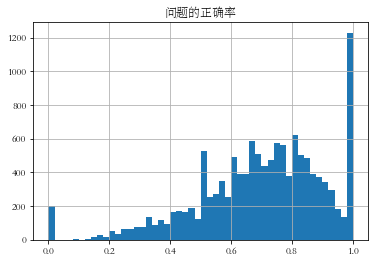

In [7]:
grouped_by_content_df = train[train["content_type_id"] != 1].groupby("content_id").agg({"answered_correctly": ["mean", "count"]})
grouped_by_content_df[('answered_correctly',  'mean')].hist(bins=50).get_figure()
plt.title("问题的正确率")
plt.show()

In [8]:
# 随便一个题回答正确的概率
avg_correct_rate = train[train["content_type_id"] != 1]["answered_correctly"].mean()
print(avg_correct_rate)

0.6563161191465746


**timestamp属性**

In [9]:
#将timestamp变成以hour为单位
interval = 1000*60*60  # 以hour为单位
bins = list(range(train['timestamp'].min(), train['timestamp'].max(), interval))
hour_label = list(range(len(bins)-1))
hour = pd.cut(train['timestamp'], include_lowest=True, bins=bins, labels=hour_label)
print(hour.head())

0    0
1    0
2    0
3    0
4    0
Name: timestamp, dtype: category
Categories (21692, int64): [0 < 1 < 2 < 3 ... 21688 < 21689 < 21690 < 21691]


In [11]:
#将hour变成一个新的属性加到原train列表中
train["hour"] = hour

      content_id  answered_correctly hour
hour                                     
0          41965            0.507661    0
1           3565            0.518093    1
2           2421            0.443205    2
3           1288            0.543478    3
4           1747            0.447624    4


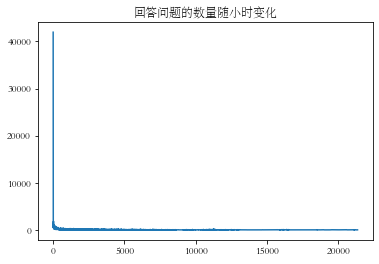

In [13]:
# 每个时间段内的答题数量分布
hour_interaction = train[train["content_type_id"] != 1].groupby("hour")\
    .agg({"content_id": "count", "answered_correctly":"mean"}) #每个小时内回答的问题的数量
hour_interaction["hour"] = hour_interaction.index
hour_interaction = hour_interaction.dropna(axis=0, how='any') #有些时间段内没有问题被回答
print(hour_interaction.head())
plt.plot(hour_interaction["hour"], hour_interaction["content_id"])
plt.title("回答问题的数量随小时变化")
plt.show()

回答问题的数量随着时间推移断崖式减少，hour的0代表的是0-1小时时间段内， 1代表1-2小时这个时间段内

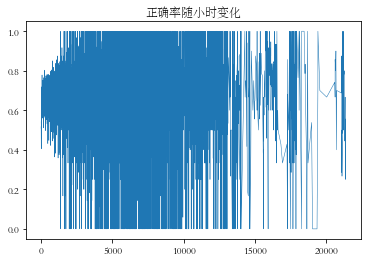

In [14]:
plt.plot(hour_interaction["hour"], hour_interaction["answered_correctly"], linewidth=0.5)
plt.title("正确率随小时变化")
plt.show()

正确率随小时变化：只能看出在某个时间段内的正确率比较集中或者说比较高，感觉不能把正确率和时间准确的联系起来。后面看到线条分布变稀疏了是因为在某些时间段内根本就没人回答问题

**针对用户的个性化分析**

In [16]:
# 每个用户回答问题的正确率和回答问题的数量
user_answer = train[train["content_type_id"] != 1].groupby("user_id")\
    .agg({"answered_correctly": "mean", "content_type_id": "count"})
print(user_answer.head())

         answered_correctly  content_type_id
user_id                                     
115                0.695652               46
124                0.233333               30
2746               0.578947               19
5382               0.672000              125
8623               0.642202              109


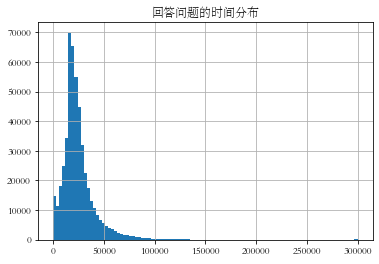

In [17]:
# 研究用户的回答问题时间属性
train[train["prior_question_elapsed_time"].notna()]["prior_question_elapsed_time"].hist(bins=100)
plt.title("回答问题的时间分布")
plt.show()

大部分问题能够在50000ms之内给出答案

In [18]:
# 把回答问题时间超过50000ms的视为犹豫问题，就是用户不是很确定这道题的答案
# 首先将回答问题的时间对准到每个题目上来
train["answer_time"] = train[train["content_type_id"] != 1]\
    .groupby("user_id")["prior_question_elapsed_time"].shift(-1)
#这里新增了一列“answer_time”到train这个列表里，这样就能将每个问题跟回答时间对应上了

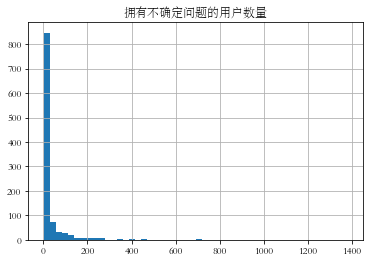

In [19]:
# 每个用户的犹豫问题的个数
uncertain_question_num = train[train["answer_time"] > 50000]\
    .groupby("user_id")["row_id"].count()
uncertain_question_num.hist(bins=50)
plt.title("拥有不确定问题的用户数量")
plt.show()

如果这个用户回答的又快正确率又高，说明这个用户是优等生

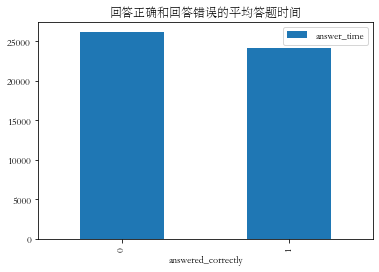

In [20]:
# 研究回答问题的时间和回答问题的准确率之间的关系
# 回答正确的问题需要的平均时间
avg_answer_time = train[train["content_type_id"] != 1]\
    .groupby("answered_correctly").agg({"answer_time": "mean"})
avg_answer_time.plot(kind="bar")
plt.title("回答正确和回答错误的平均答题时间")
plt.show()

这个有点意外，我本来以为回答的正确的问题一般回答的比较快，因为很确定答案，不过这里只是表现出了微弱的优势。 那下面我就研究一下回答时间长的问题的准确率和回答时间短的问题的准确率

In [21]:
print(train["answer_time"].
print(train["answer_time"].min())

300000.0
0.0


E:\tool_box\Anaconda\lib\site-packages\matplotlib\axes\_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


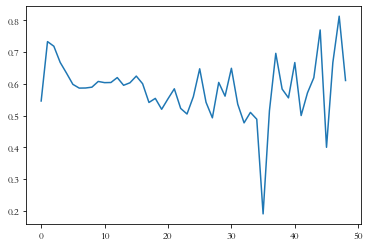

In [22]:
# 答题时间与问题的准确率之间的关系
bins = np.linspace(train["answer_time"].min(), train["answer_time"].max(), 50)
time = pd.cut(train["answer_time"], include_lowest=True, bins=bins)
answer_time_correct = pd.DataFrame()
answer_time_correct["answered_correctly"] = train["answered_correctly"]
answer_time_correct["time_interval"] = time
avg_time_correctly = answer_time_correct[answer_time_correct["answered_correctly"] != -1]\
    .groupby("time_interval").agg({"answered_correctly": "mean"})
plt.plot(avg_time_correctly)
plt.show()

上图显示的是回答问题的时间和准确率之间的关系，只能看到在某一个时间段准确率奇低，没有明显的函数关系。